In [1]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    from ajax import Prior, Likelihood, Variational, ADVI
except:
    %pip install -qq git+https://github.com/patel-zeel/ajax
    from ajax import Prior, Likelihood, Variational, ADVI
    
from ajax.utils import fill_params
from tqdm import trange

from jax.config import config
config.update("jax_enable_x64", True)

### Generate dataset

In [2]:
# Define prior
class NoPrior:
    event_shape = tfp.internal.batch_shape_lib.tf.TensorShape([2])
    batch_shape = tfp.internal.batch_shape_lib.tf.TensorShape([])
    
    def log_prob(self, sample):
        return jnp.array(0.0)

prior = Prior(distributions={"mean": NoPrior()})

# Define likelihood
def link_function(sample):
    mean = sample["mean"]
    cov = jnp.array([[0.28, 0.2], [0.2, 0.31]])
    return {'loc': mean, "covariance_matrix": cov}

likelihood = Likelihood(likelihood=tfd.MultivariateNormalFullCovariance, link_function=link_function)

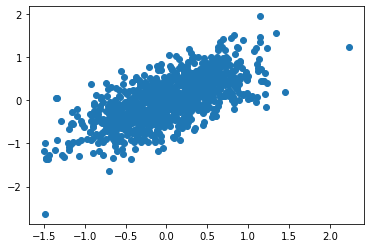

In [3]:
# Generate samples
N = 1000
seed = jax.random.PRNGKey(0)
mean_sample = {'mean': jnp.array([0.0, 0.0])}
data = likelihood.sample(seed=seed, params=mean_sample, sample_shape=(N,))

# Plot the samples
plt.scatter(data[:, 0], data[:, 1]);

## ADVI

In [4]:
def fit_advi(vi_type, epochs):
    bijectors = {'mean': tfb.Identity()}
    variational = Variational(prior, bijectors, vi_type=vi_type)

    advi = ADVI(prior, likelihood, variational, data)
    
    # n_samples = 10
    optimizer = optax.adam(learning_rate=0.1)
    params = variational.get_params()
    state = optimizer.init(params)

    value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss), static_argnames=['n_samples'])
    seed = jax.random.PRNGKey(0)
    for _ in trange(epochs):
        seed = jax.random.split(seed, 1)[0]
        loss_value, grads = value_and_grad_fun(params, seed)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
    return jax.tree_leaves(variational.transform_dist(params['mean']))

## Fit Mean-field  VI

In [7]:
results = {}

In [9]:
loc, scale = fit_advi(vi_type='mean_field', epochs=1000)
print("loc", loc)
print("var", scale**2)
results['mean_field'] = {'loc': loc, 'var': scale**2}

100%|██████████| 1000/1000 [00:44<00:00, 22.71it/s]


loc [-0.01986062  0.01559812]
var [0.00475298 0.00752408]


## Fit Full-rank VI

In [46]:
loc, L_chol = fit_advi(vi_type='full_rank', epochs=200)
print("loc", loc)
print("covariance_matrix", L_chol@L_chol.T)
results['full_rank'] = {'loc': loc, 'covar': L_chol@L_chol.T}

100%|██████████| 200/200 [00:04<00:00, 49.64it/s]

loc [-0.02761467  0.02063434]
covariance_matrix [[ 0.00086134 -0.00188114]
 [-0.00188114  0.01165943]]


## Closed form

In [10]:
prior_cov = jnp.diag(jax.tree_leaves(prior.distributions['mean'])[1])
sigma_y_inv = jnp.linalg.inv(jnp.array([[0.28, 0.2], [0.2, 0.31]]))
optimal_cov_inv = jnp.linalg.inv(prior_cov) + N*sigma_y_inv
optimal_cov = jnp.linalg.inv(optimal_cov_inv)

optimal_mean = optimal_cov@(sigma_y_inv@(N*data.mean(axis=0)))
results['analytic'] = {'loc': optimal_mean, "covar": optimal_cov}

IndexError: list index out of range

In [11]:
1/sigma_y_inv

NameError: name 'sigma_y_inv' is not defined

## Results

In [10]:
results['mean_field']

{'loc': DeviceArray([-0.0412429 ,  0.01531224], dtype=float32),
 'var': DeviceArray([0.04225402, 0.02714199], dtype=float32)}

In [11]:
results['full_rank']

{'loc': DeviceArray([-0.07759243,  0.05348505], dtype=float32),
 'covar': DeviceArray([[ 0.01821143, -0.01231783],
              [-0.01231783,  0.03992188]], dtype=float32)}

In [12]:
results['analytic']

{'loc': DeviceArray([-0.00622634, -0.01124652], dtype=float32),
 'covar': DeviceArray([[0.00027882, 0.00019883],
              [0.00019883, 0.00030865]], dtype=float32)}

## Appendix

In [30]:
real = tfd.MultivariateNormalFullCovariance(loc=jnp.zeros(2), covariance_matrix=jnp.array([[0.28, 0.2], [0.2, 0.31]]))

def loss(params, seed):
#     proposal = tfd.MultivariateNormalTriL(loc=params['mean'], scale_tril=params['tril'])
    proposal = tfd.MultivariateNormalDiag(loc=params['mean'], scale_diag=jnp.exp(params['log_scale']))
    sample = proposal.sample(seed=seed, sample_shape=100)
    return jnp.mean(proposal.log_prob(sample) - real.log_prob(sample))

# params = {'mean': jnp.ones(2), 'tril': jnp.array([[1.0, 0.0], [0.0, 1.0]])}
params = {'mean': jnp.zeros(2), 'log_scale': jnp.ones(2)}

optimizer = optax.sgd(learning_rate=0.1)
state = optimizer.init(params)

value_and_grad_fun = jax.jit(jax.value_and_grad(loss))
epochs = 1000
seed = jax.random.PRNGKey(0)
losses = []
for _ in trange(epochs):
    seed = jax.random.split(seed)[0]
    loss_value, grads = value_and_grad_fun(params, seed)
    losses.append(loss_value)
    updates, state = optimizer.update(grads, state)
    params = optax.apply_updates(params, updates)

# params['mean'], params['tril']@params['tril'].T
params['mean'], jnp.exp(params['log_scale'])**2

100%|██████████| 1000/1000 [00:01<00:00, 778.61it/s]


(DeviceArray([-0.02900433,  0.01556963], dtype=float64),
 DeviceArray([0.15399672, 0.17595273], dtype=float64))

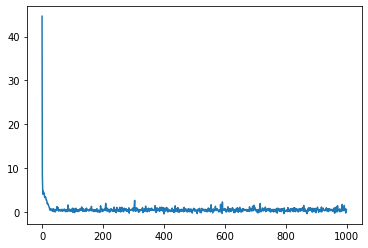

In [28]:
plt.plot(losses);

In [33]:
1/jnp.linalg.inv(jnp.array([[0.28, 0.2], [0.2, 0.31]]))

DeviceArray([[ 0.15096774, -0.234     ],
             [-0.234     ,  0.16714286]], dtype=float64)

In [18]:
jax.tree_leaves(tfd.MultivariateNormalDiag(loc=jnp.zeros(2), scale_diag=jnp.ones(2)))

[DeviceArray([0., 0.], dtype=float64), DeviceArray([1., 1.], dtype=float64)]